In [3]:
import pennylane as qml
from qiskit.quantum_info import random_unitary
from qiskit.circuit.library import UnitaryGate
from sync import cost as cost_func
from sync import circuit, constant
import pennylane.numpy as np
import pennylane as qml
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
num_qubits = 3
num_layers = 5
num_blocks = num_qubits*(num_qubits-1)//2
active_blocks = np.ones(num_blocks * num_layers)
thetas = np.random.uniform(0, 2*np.pi, constant.num_params_on_active_blocks(active_blocks), requires_grad=True)

def u3cry(thetas):
    k, index_params = 0, 0
    for _ in range(num_layers):
        for i in range(num_qubits):
            for j in range(i + 1, num_qubits):
                if active_blocks[k] == 1:
                    qml.U3(thetas[index_params],thetas[index_params + 1],thetas[index_params + 2],i)
                    qml.U3(thetas[index_params + 3],thetas[index_params + 4],thetas[index_params + 5],j)
                    qml.CNOT([j, i])
                    index_params += 6
                k += 1

target = UnitaryGate(random_unitary(2**num_qubits))
def cost(thetas):
    matrix = qml.matrix(u3cry, wire_order=list(range(num_qubits)))(thetas)
    return cost_func.c_hst(matrix, target)

steps = 1000
costs = []
opt = qml.AdamOptimizer(stepsize = 0.05)
for n in range(steps):
    thetas, prev_cost = opt.step_and_cost(cost, thetas)
    costs.append(prev_cost)

# grad_fn = qml.grad(func = cost)
# for i in range(steps):
# 	gradient = grad_fn(thetas)
# 	thetas = thetas - 0.1 * gradient
# 	costs.append(cost(thetas))

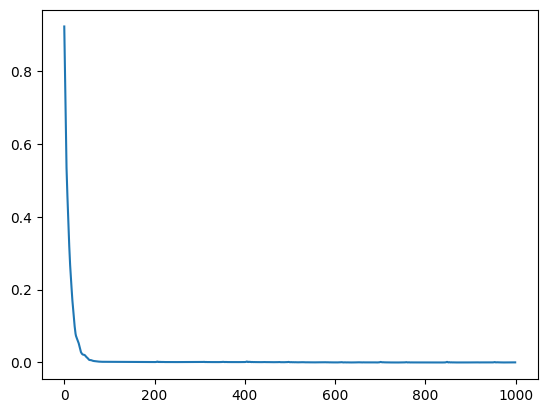

In [44]:
import matplotlib.pyplot as plt
plt.plot(costs)

In [42]:
costs[-1]

tensor(0.00068422, requires_grad=True)

In [44]:
import pennylane as qml
from pennylane import numpy as np

# Define the number of qubits and the device
n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)

# Define the quantum circuit
@qml.qnode(dev, diff_method="parameter-shift")
def circuit(theta):
    # Apply the parameterized unitary U(theta)
    qml.RX(theta[0], wires=0)
    qml.RY(theta[1], wires=1)
    qml.CNOT(wires=[0, 1])
    # Return probabilities of all computational basis states
    return qml.probs(wires=[0, 1])

# Define the cost function
def cost(theta):
    # Get the probabilities from the quantum circuit
    probs = circuit(theta)
    # Extract p_0 (probability of |00>)
    p_0 = probs[0]
    # Compute the cost function
    return 1 - p_0

# Initialize parameters
theta = np.array([0.5, 0.1], requires_grad=True)

# Compute the gradient of the cost function w.r.t. theta
grad_fn = qml.grad(func = cost)

steps = 100
costs = []
for i in range(steps):
	gradient = grad_fn(theta)
	theta = theta - 0.1 * gradient
	costs.append(cost(theta))
print("Theta:", theta)
print("Gradient:", gradient)


Theta: [0.0030328  0.00061315]
Gradient: [0.00159621 0.00032271]


In [17]:
costs[-1]

2.3934557213944885e-06

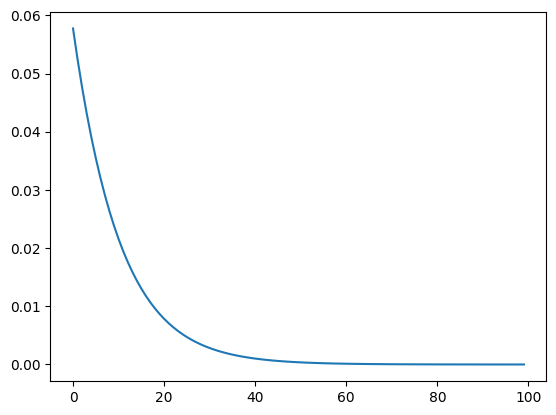

In [16]:
import matplotlib.pyplot as plt
plt.plot(costs)

In [30]:
import pennylane as qml
from pennylane import numpy as np

# Define the number of qubits and the device
n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)

# Define the quantum circuit
@qml.qnode(dev)
def circuit(theta):
    # Apply the parameterized unitary U(theta)
    qml.RX(theta[0], wires=0)
    qml.RY(theta[1], wires=1)
    qml.CNOT(wires=[0, 1])
    # Return probabilities of all computational basis states
    return qml.probs(wires=[0, 1])

# Define the cost function
def cost(theta):
    # Get the probabilities from the quantum circuit
    probs = circuit(theta)
    # Extract p_0 (probability of |00>)
    p_0 = probs[0]
    # Compute the cost function
    return p_0**2 - 1

# Parameter-shift rule implementation
def parameter_shift_gradient(cost_fn, theta, idx):
    """Compute the gradient of the cost function with respect to a single parameter using the parameter-shift rule."""
    shifted = theta.copy()
    
    # Shift parameter by +pi/2
    shifted[idx] += np.pi / 2
    forward = cost_fn(shifted)
    
    # Shift parameter by -pi/2
    shifted[idx] -= np.pi
    backward = cost_fn(shifted)
    
    # Compute gradient using the parameter-shift rule
    return (forward - backward) / 2

# Full gradient computation
def compute_full_gradient(cost_fn, theta):
    gradients = np.zeros_like(theta)
    for i in range(len(theta)):
        gradients[i] = parameter_shift_gradient(cost_fn, theta, i)
    return gradients

# Initialize parameters
theta = np.array([0.5, 0.1], requires_grad=False)

# Compute the gradient using the parameter-shift rule
gradient = compute_full_gradient(cost, theta)

print("Theta:", theta)
print("Gradient:", gradient)


Theta: [0.5 0.1]
Gradient: [-0.2385167  -0.04399305]
